In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import TheilSenRegressor
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from pyscipopt import Model, quicksum, multidict
import os
os.chdir('/Users/user/PycharmProjects/Shell_hachakton_2023')

In [2]:
data = pd.read_csv('data/Biomass_History.csv', index_col=0)
dist = pd.read_csv('data/Distance_Matrix.csv', index_col=0)

In [3]:
def preprocessing(data ,dist, biomass_percentage):
    total_biomass = max(data['2018'].sum(), data['2019'].sum())
    average_biomass = data.iloc[:, -2:].mean(axis=1)
    sorted_dist = dist.sum(axis=1).sort_values(ascending=True)
    indices = []
    biomass_to_collect = []
    i = 0
    while sum(biomass_to_collect) <= biomass_percentage * total_biomass:
        biomass_to_collect.append(average_biomass[sorted_dist.index[i]])
        indices.append(sorted_dist.index[i])
        i += 1

    return indices

In [4]:
def predict_biomass(data):
    reg = TheilSenRegressor()
    X = np.arange(0,8).reshape(-1,1)
    pred_list = []
    for i in range(0, len(data)):
        y = data.iloc[i, 2:].values.ravel()
        reg.fit(X,y)
        preds = reg.predict(np.array([8, 9]).reshape(-1, 1))
        pred_list.append(list(preds))
    pred_df = pd.DataFrame(np.array(pred_list).squeeze(), columns=['2018', '2019'],
                               index=np.arange(0, len(data)))
    data_predicted = pd.concat([data, pred_df], axis=1)

    return data_predicted

In [5]:
def CFLP(I,J,d,M,c,n):
    model = Model("flp")
    x,y = {},{}

    for j in J:
        y[j] = model.addVar(vtype="B", name="y(%s)"%j)
        for i in I:
            x[i,j] = model.addVar(vtype="C", name="x(%s,%s)"%(i,j))
    for i in I:
        model.addCons(quicksum(x[i,j] for j in J) == d[i], "Demand(%s)"%i) # All demands should be met
    for j in M:
        model.addCons(quicksum(x[i,j] for i in I) <= M[j]*y[j], "Capacity(%s)"%i) # All facility should not violate capacity constraint
    for (i,j) in x:
        model.addCons(x[i,j] <= d[i]*y[j], "Strong(%s,%s)"%(i,j)) # Can't be delivered more than demand
    model.addCons(quicksum(y[j] for j in J) <= n, "Number_of_facilities(%s)"%j)
    model.setObjective(
        quicksum(M[j]*y[j] - quicksum(x[i,j] for i in I) for j in J) +
        0.001 * quicksum(c[i,j]*x[i,j] for i in I for j in J),
        "minimize")
    model.data = x,y
    return model

In [6]:
def CFLP_second_year(I,J,d,M,c,y):
    model = Model("flp")
    x = {}

    for j in J:
        for i in I:
            x[i,j] = model.addVar(vtype="C", name="x(%s,%s)"%(i,j))
    for i in I:
        model.addCons(quicksum(x[i,j] for j in J) == d[i], "Demand(%s)"%i) # All demands should be met
    for j in M:
        model.addCons(quicksum(x[i,j] for i in I) <= M[j]*y[j], "Capacity(%s)"%i) # All facility should not violate capacity constraint
    for (i,j) in x:
        model.addCons(x[i,j] <= d[i]*y[j], "Strong(%s,%s)"%(i,j)) # Can't be delivered more than demand
    model.setObjective(
        quicksum(M[j]*y[j] - quicksum(x[i,j] for i in I) for j in J) +
        0.001 * quicksum(c[i,j]*x[i,j] for i in I for j in J),
        "minimize")
    model.data = x
    return model

In [7]:
def kmedian(I, J, c, k):
    model = Model("k-median")
    x, y = {}, {}
    for j in J:
        y[j] = model.addVar(vtype="B", name="y(%s)" % j)
        for i in I:
            x[i, j] = model.addVar(vtype="B", name="x(%s,%s)" % (i, j))
    for i in I:
        model.addCons(quicksum(x[i, j] for j in J) == 1, "Assign(%s)" % i)
        for j in J:
            model.addCons(x[i, j] <= y[j], "Strong(%s,%s)" % (i, j))
    model.addCons(quicksum(y[j] for j in J) == k, "Facilities")
    model.setObjective(quicksum(c[i, j] * x[i, j] for i in I for j in J), "minimize")
    model.data = x, y

    return model

### Prediction & preprocessing

In [9]:
prediction = predict_biomass(data)
indices = preprocessing(prediction, dist, biomass_percentage=0.85)
prediction = prediction.loc[indices]
prediction

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
1161,22.57257,71.80919,235.627228,292.933227,109.337555,218.015884,273.378418,295.026428,228.876297,278.418823,283.128747,289.109438
1167,22.57257,72.28694,215.448059,185.085129,163.928558,191.308227,152.546555,216.821899,150.394745,151.264252,136.874322,129.972081
1110,22.65317,72.12769,96.775566,65.974236,54.824028,70.381401,60.916252,72.966026,66.482132,74.143700,69.036928,69.350633
1166,22.57257,72.20732,189.149582,163.966141,135.268372,158.399139,138.744781,173.667236,138.247620,142.772217,128.016128,122.879006
1162,22.57257,71.88882,129.218277,159.620987,71.338722,123.937584,140.206162,144.786942,125.013153,157.485489,143.588737,145.870537
...,...,...,...,...,...,...,...,...,...,...,...,...
1940,21.52477,73.24244,152.239365,165.956528,113.632698,219.517029,264.666016,217.604568,233.130936,246.566513,260.161627,273.650861
32,24.50698,71.49069,121.033234,177.738617,170.079651,111.813431,164.977264,118.140984,150.813324,134.183136,137.772906,132.762417
1436,22.25017,74.03869,33.334621,32.695362,82.081978,82.081978,82.081978,32.695362,88.723534,33.334621,80.729079,85.418798
1445,22.16957,69.73894,56.511650,15.420983,76.651039,77.357429,76.905403,15.290696,24.578590,56.807507,56.716721,56.371425


In [44]:
def cluster_preprocessing(data, num_clusters=5, num_closest_points=10):
    # Selecting the longitude and latitude columns
    X = data[['Longitude', 'Latitude']]

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X)

    # Get cluster centers
    cluster_centers = kmeans.cluster_centers_

    # Find the 5 closest points to each cluster center
    closest_points = []
    closest_points_indices = []

    for cluster_center in cluster_centers:
        # Fit a NearestNeighbors model on the data points belonging to the current cluster
        cluster_indices = (kmeans.labels_ == kmeans.predict([cluster_center])).nonzero()[0]
        cluster_data = X.iloc[cluster_indices]

        nn_model = NearestNeighbors(n_neighbors=num_closest_points)
        nn_model.fit(cluster_data)

        # Find the indices of the closest points in the cluster
        _, indices = nn_model.kneighbors([cluster_center])

        # Append the closest points to the list
        closest_points.extend(cluster_data.iloc[indices[0]].values)

        # Append the closest points' indices to the list
        closest_points_indices.extend(cluster_indices[indices[0]])

    closest_points_indices = np.array(closest_points_indices)

    data.reset_index()
    print(data)
    detected_points_df = data.loc[closest_points_indices,['Index']]

    return cluster_centers, closest_points, detected_points_df.index

In [45]:
cluster_centers, closest_points, closest_points_indices = cluster_preprocessing(data=prediction, num_clusters=10, num_closest_points=10)

C:\Users\user\anaconda3\envs\SCIP\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\SCIP\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\user\anaconda3\envs\SCIP\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\user\anaconda3\envs\SCIP\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\user\anaconda3\envs\SCIP\lib\site-pack

      Latitude  Longitude        2010        2011        2012        2013  \
1161  22.57257   71.80919  235.627228  292.933227  109.337555  218.015884   
1167  22.57257   72.28694  215.448059  185.085129  163.928558  191.308227   
1110  22.65317   72.12769   96.775566   65.974236   54.824028   70.381401   
1166  22.57257   72.20732  189.149582  163.966141  135.268372  158.399139   
1162  22.57257   71.88882  129.218277  159.620987   71.338722  123.937584   
...        ...        ...         ...         ...         ...         ...   
1940  21.52477   73.24244  152.239365  165.956528  113.632698  219.517029   
32    24.50698   71.49069  121.033234  177.738617  170.079651  111.813431   
1436  22.25017   74.03869   33.334621   32.695362   82.081978   82.081978   
1445  22.16957   69.73894   56.511650   15.420983   76.651039   77.357429   
1934  21.52477   72.76469  246.271149  292.879913  272.734345  225.025284   

            2014        2015        2016        2017        2018        201

KeyError: '[909, 964, 33, 20, 28, 114, 47, 967, 780, 785, 708, 911, 771, 843, 846, 779, 908, 915, 839, 966, 971, 789, 237, 27, 715, 648, 788, 716] not in index'

In [43]:
closest_points_indices

array([1000,  909, 1017, 1155,  897,  813, 1045,  964, 1115, 1116,   33,
        111,   20,   28,  105,   74,  114,   47,  110,  146, 1158, 1185,
        967, 1079,  918, 1052, 1255,  817, 1022, 1244,  780,  785,  708,
        911,  681,  858,  935,  741,  771,  843,  829,  868,  807,  887,
        846,  872,  940,  679,  779, 1049,  927,  899,  989,  986,  765,
        863,  908,  954,  915, 1125,  728,  811,  763,  752,  632,  888,
        822,  625,  694,  942,  839,  945,  966,  881,  971,  789,  933,
        814,  754, 1041,  129,  237,   70,  156,  186,  206,  104,   27,
        246,  143,  826,  715,  769, 1108,  648,  831,  788,  768, 1037,
        716], dtype=int64)

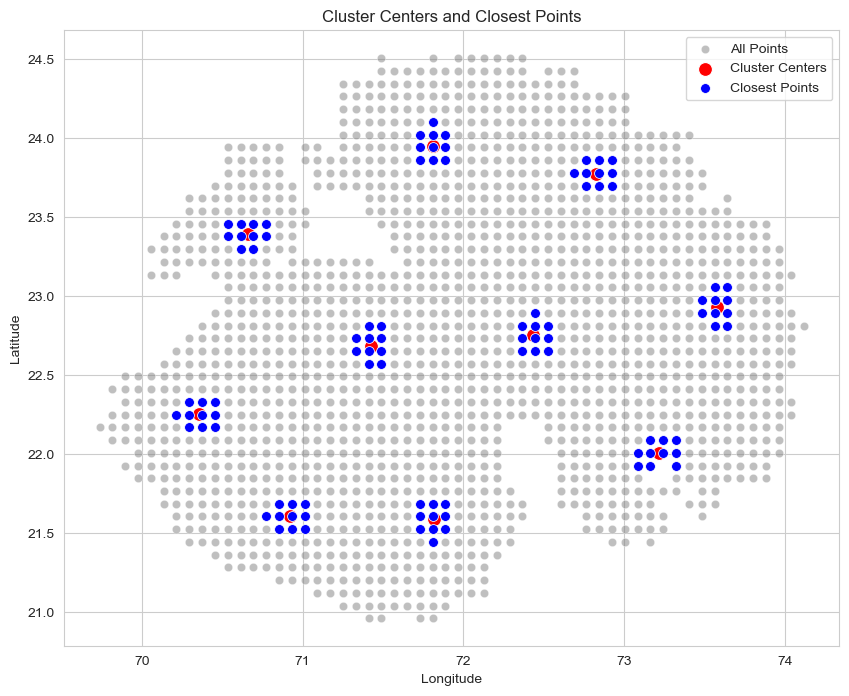

In [39]:
# Plotting
plt.figure(figsize=(10, 8))

# Plot all points from the dataset
sns.scatterplot(data=prediction, x='Longitude', y='Latitude', color='gray', alpha=0.5, label='All Points')

# Plot cluster centers
sns.scatterplot(data=pd.DataFrame(cluster_centers, columns=['longitude', 'latitude']),
                x='longitude', y='latitude', color='red', s=100, label='Cluster Centers')

# Plot closest points
closest_points_df = pd.DataFrame(closest_points, columns=['longitude', 'latitude'])
sns.scatterplot(data=closest_points_df, x='longitude', y='latitude', color='blue', s=50, label='Closest Points')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cluster Centers and Closest Points')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Spatial Biomass Distribution')

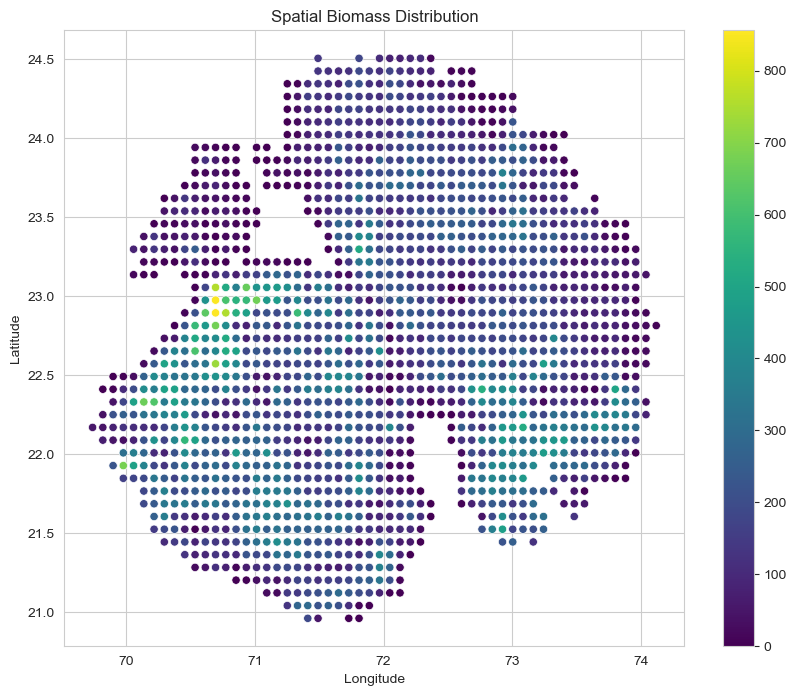

In [10]:
year = '2018'

plt.figure(figsize=(10, 8))
ax = sns.scatterplot(data=prediction, x='Longitude', y='Latitude', hue=year, palette='viridis')

norm = plt.Normalize(prediction[year].min(), prediction[year].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
ax.get_legend().remove()
ax.figure.colorbar(ax=ax, mappable=sm)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Biomass Distribution')

In [16]:
number_of_depots = max(int(prediction['2018'].sum() / 20000) + 1, int(prediction['2019'].sum() / 20000) + 1)
number_of_depots

18

## First year 2018

### Depot locations

In [39]:
year = '2018'
max_number_of_depots = 25
depot_cap = 20000

# Get site indices and its biomass demand
biomass = prediction[year]
site_locations, biomass_demand = multidict(dict(biomass))

# Get indices where depot can be located
capacity = pd.Series(depot_cap, index=prediction[year].index) # assuming all possible locations
possible_depot_locations, depot_capacity = multidict(dict(capacity))

# Cost matrix of transport from site_indices to depot_indices
site_depot_dist = dist.iloc[site_locations, possible_depot_locations].reset_index().melt(id_vars='index')
site_depot_dist['variable'] =  site_depot_dist['variable'].astype('int')
site_depot_dist = {(row[0], row[1]):row[2] for row in site_depot_dist.values}
site_depot_dist

{(0.0, 0.0): 0.0,
 (1.0, 0.0): 11.3769,
 (2.0, 0.0): 20.4557,
 (3.0, 0.0): 38.1227,
 (4.0, 0.0): 45.381,
 (5.0, 0.0): 54.9915,
 (6.0, 0.0): 78.968,
 (7.0, 0.0): 118.675,
 (8.0, 0.0): 102.6639,
 (9.0, 0.0): 113.4309,
 (10.0, 0.0): 122.5989,
 (11.0, 0.0): 129.9333,
 (12.0, 0.0): 152.2615,
 (13.0, 0.0): 161.53289999999998,
 (14.0, 0.0): 25.7233,
 (15.0, 0.0): 9.5233,
 (16.0, 0.0): 14.0595,
 (17.0, 0.0): 24.3136,
 (18.0, 0.0): 37.8461,
 (19.0, 0.0): 45.7319,
 (20.0, 0.0): 56.948,
 (21.0, 0.0): 118.5574,
 (22.0, 0.0): 112.3636,
 (23.0, 0.0): 105.9454,
 (24.0, 0.0): 107.981,
 (25.0, 0.0): 111.788,
 (26.0, 0.0): 120.5127,
 (27.0, 0.0): 146.31529999999998,
 (28.0, 0.0): 139.4,
 (29.0, 0.0): 30.3211,
 (30.0, 0.0): 21.160400000000003,
 (31.0, 0.0): 21.4279,
 (32.0, 0.0): 30.824,
 (33.0, 0.0): 33.2092,
 (34.0, 0.0): 50.2884,
 (35.0, 0.0): 64.80890000000001,
 (36.0, 0.0): 72.04180000000001,
 (37.0, 0.0): 108.9288,
 (38.0, 0.0): 88.04780000000001,
 (39.0, 0.0): 97.8621,
 (40.0, 0.0): 104.9229,
 (41

In [ ]:
model = kmedian(I = site_locations,
                J = possible_depot_locations,
                c = site_depot_dist,
                k = number_of_depots)
model.optimize()
x,y = model.data
EPS = 1.e-6
depot_locations = [j for j in y if model.getVal(y[j]) > EPS]
depot_routes = [(i,j) for (i,j) in x if model.getVal(x[i,j]) > EPS]
print("Optimal value=", model.getObjVal())
print("Depots at nodes:", depot_locations)
print("Site-Depot routes (from,to):", depot_routes)

In [36]:
boolean_depot_locations = {j:model.getVal(y[j]) for j in possible_depot_locations}

In [38]:
model3 = CFLP_second_year(I = site_locations,
                          J = possible_depot_locations,
                          d = biomass_demand,
                          M = depot_capacity,
                          c = site_depot_dist,
                          y = boolean_depot_locations)
model3.optimize()
EPS = 1.e-6
x3 = model3.data
depot_routes = [(i,j) for (i,j) in x3 if model3.getVal(x3[i,j]) > EPS]
print("Optimal value=", model3.getObjVal())
print("Site-Depot routes (from,to):", depot_routes)

Optimal value= 353178.7455490071
Site-Depot routes (from,to): [(229, 136), (138, 136), (136, 136), (217, 217), (338, 217), (101, 217), (705, 457), (460, 457), (574, 457), (404, 457), (500, 688), (688, 688), (760, 688), (661, 921), (856, 921), (1040, 921), (970, 975), (790, 975), (975, 975), (1006, 1065), (1065, 1065), (1155, 1100), (1153, 1100), (1157, 1100), (1101, 1100), (1207, 1100), (1307, 1307), (1560, 1307), (1236, 1426), (1426, 1426), (1492, 1492), (1615, 1492), (1432, 1492), (1490, 1492), (1643, 1643), (1463, 1643), (1639, 1643), (1704, 1815), (1537, 1815), (1868, 1815), (1938, 1938), (2049, 1938), (2067, 2067), (2069, 2067), (1901, 2067), (2108, 2108), (2215, 2215), (2414, 2373), (2345, 2373), (2373, 2373)]


In [14]:
model1 = CFLP(I = site_locations,
              J = possible_depot_locations,
              d = biomass_demand,
              M = depot_capacity,
              c = site_depot_dist,
              n = max_number_of_depots)
model1.optimize()
EPS = 1.e-6
x,y = model1.data
depot_routes = [(i,j) for (i,j) in x if model1.getVal(x[i,j]) > EPS]
depot_locations = [j for j in y if model1.getVal(y[j]) > EPS]
print("Optimal value=", model1.getObjVal())
print("Depots at nodes:", depot_locations)
print("Site-Depot routes (from,to):", depot_routes)

Optimal value= 13526.187144551646
Depots at nodes: [1161]
Site-Depot routes (from,to): [(1787, 1161), (1474, 1161), (2098, 1161), (841, 1161), (1001, 1161), (1410, 1161), (1859, 1161), (226, 1161), (781, 1161), (2342, 1161), (1297, 1161), (1100, 1161), (2124, 1161), (1336, 1161), (2052, 1161), (2120, 1161), (2015, 1161), (364, 1161), (595, 1161), (1087, 1161), (1021, 1161), (912, 1161), (1321, 1161), (1539, 1161), (2073, 1161), (2378, 1161), (116, 1161), (773, 1161), (1186, 1161), (2139, 1161), (293, 1161), (380, 1161), (2379, 1161), (592, 1161), (940, 1161), (2242, 1161), (2363, 1161), (1680, 1161), (1751, 1161), (2295, 1161), (877, 1161), (1288, 1161), (12, 1161), (686, 1161), (1189, 1161), (2158, 1161), (1532, 1161), (1694, 1161), (960, 1161), (1667, 1161)]


### Refinery locations

In [120]:
year = '2018'
max_number_of_refineries = 5
cap = 100000
EPS = 1.e-6

# Get pellet demand at each depot
pellet_demand = {dl:sum([model1.getVal(x[sl,dl]) for sl in site_locations if model1.getVal(x[sl,dl]) > EPS]) for dl in depot_locations}

# Get indices where refinery can be located
capacity = pd.Series(cap, index=prediction[year].index) # assuming all possible locations
possible_refinery_locations, refinery_capacity = multidict(dict(capacity))

# Cost matrix of transport from depot_indices to refinery_indices
depot_refinery_dist = dist.iloc[depot_locations, possible_refinery_locations].reset_index().melt(id_vars='index')
depot_refinery_dist['variable'] = depot_refinery_dist['variable'].astype('int')
depot_refinery_dist = {(row[0], row[1]):row[2] for row in depot_refinery_dist.values}
depot_refinery_dist

{(1211.0, 0.0): 328.7382,
 (1211.0, 1.0): 326.4905,
 (1211.0, 2.0): 327.0933,
 (1211.0, 3.0): 320.3765,
 (1211.0, 4.0): 315.59709999999995,
 (1211.0, 5.0): 330.3288,
 (1211.0, 6.0): 317.6373,
 (1211.0, 7.0): 312.8919,
 (1211.0, 8.0): 328.8788,
 (1211.0, 9.0): 307.6478,
 (1211.0, 10.0): 316.8159,
 (1211.0, 11.0): 337.0576,
 (1211.0, 12.0): 321.6499,
 (1211.0, 13.0): 330.9213,
 (1211.0, 14.0): 323.932,
 (1211.0, 15.0): 319.2149,
 (1211.0, 16.0): 315.7363,
 (1211.0, 17.0): 313.2567,
 (1211.0, 18.0): 309.1315,
 (1211.0, 19.0): 305.4975,
 (1211.0, 20.0): 304.87640000000005,
 (1211.0, 21.0): 312.7743,
 (1211.0, 22.0): 306.5805,
 (1211.0, 23.0): 300.16240000000005,
 (1211.0, 24.0): 302.198,
 (1211.0, 25.0): 306.0049,
 (1211.0, 26.0): 314.72970000000004,
 (1211.0, 27.0): 315.7037,
 (1211.0, 28.0): 308.7884,
 (1211.0, 29.0): 328.5299,
 (1211.0, 30.0): 319.36920000000003,
 (1211.0, 31.0): 307.3103,
 (1211.0, 32.0): 302.35209999999995,
 (1211.0, 33.0): 298.5464,
 (1211.0, 34.0): 296.6891,
 (1211.

In [121]:
depot_locations

[1211]

In [122]:
pellet_demand

{1211: 1610.8851027178634}

In [123]:
biomass.sum()

1610.8851027178637

In [124]:
model2 = CFLP(I = depot_locations,
             J = possible_refinery_locations,
             d = pellet_demand,
             M = refinery_capacity,
             c = depot_refinery_dist,
             n = max_number_of_refineries)
model2.optimize()
EPS = 1.e-6
x,y = model2.data
refinery_routes = [(i,j) for (i,j) in x if model2.getVal(x[i,j]) > EPS]
refinery_locations = [j for j in y if model2.getVal(y[j]) > EPS]
print("Optimal value=", model2.getObjVal())
print("Refineries at nodes:", refinery_locations)
print("Depot-Refinery routes (from,to):", refinery_routes)

Optimal value=presolving:
(round 1, fast)       0 del vars, 0 del conss, 0 add conss, 2418 chg bounds, 0 chg sides, 2418 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
   (0.0s) running MILP presolver
   (0.0s) MILP presolver (2 rounds): 0 aggregations, 0 fixings, 0 bound changes
(round 2, medium)     0 del vars, 4838 del conss, 2420 add conss, 2418 chg bounds, 0 chg sides, 2418 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 3, exhaustive) 0 del vars, 4838 del conss, 2420 add conss, 2418 chg bounds, 0 chg sides, 2418 chg coeffs, 2418 upgd conss, 0 impls, 0 clqs
   (0.1s) probing: 51/2418 (2.1%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.1s) probing aborted: 50/50 successive totally useless probings
   (0.1s) symmetry computation started: requiring (bin +, int -, cont +), (fixed: bin -, int +, cont -)
   (0.1s) symmetry computation finished: 10 generators found (max: 1500, log10 of symmetry group size: 3.0)
(round 4, exhaustive) 0 del vars, 4838 del conss, 2430 add 

### Save locations

In [80]:
boolean_depot_locations = {j:model1.getVal(y[j]) for j in possible_depot_locations}
boolean_depot_locations

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.0,
 29: 0.0,
 30: 0.0,
 31: 0.0,
 32: 0.0,
 33: 0.0,
 34: 0.0,
 35: 0.0,
 36: 0.0,
 37: 0.0,
 38: 0.0,
 39: 0.0,
 40: 0.0,
 41: 0.0,
 42: 0.0,
 43: 0.0,
 44: 0.0,
 45: 0.0,
 46: 0.0,
 47: 0.0,
 48: 0.0,
 49: 0.0,
 50: 0.0,
 51: 0.0,
 52: 0.0,
 53: 0.0,
 54: 0.0,
 55: 0.0,
 56: 0.0,
 57: 0.0,
 58: 0.0,
 59: 0.0,
 60: 0.0,
 61: 0.0,
 62: 0.0,
 63: 0.0,
 64: 0.0,
 65: 0.0,
 66: 0.0,
 67: 0.0,
 68: 0.0,
 69: 0.0,
 70: 0.0,
 71: 0.0,
 72: 0.0,
 73: 0.0,
 74: 0.0,
 75: 0.0,
 76: 0.0,
 77: 0.0,
 78: 0.0,
 79: 0.0,
 80: 0.0,
 81: 0.0,
 82: 0.0,
 83: 0.0,
 84: 0.0,
 85: 0.0,
 86: 0.0,
 87: 0.0,
 88: 0.0,
 89: 0.0,
 90: 0.0,
 91: 0.0,
 92: 0.0,
 93: 0.0,
 94: 0.0,
 95: 0.0,
 96: 0.0,
 97: 0.0,
 98: 0.0,
 99: 0.0,
 100: 0.0,

In [81]:
boolean_refinery_locations = {j:model2.getVal(y[j]) for j in possible_refinery_locations}
boolean_refinery_locations

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.0,
 29: 0.0,
 30: 0.0,
 31: 0.0,
 32: 0.0,
 33: 0.0,
 34: 0.0,
 35: 0.0,
 36: 0.0,
 37: 0.0,
 38: 0.0,
 39: 0.0,
 40: 0.0,
 41: 0.0,
 42: 0.0,
 43: 0.0,
 44: 0.0,
 45: 0.0,
 46: 0.0,
 47: 0.0,
 48: 0.0,
 49: 0.0,
 50: 0.0,
 51: 0.0,
 52: 0.0,
 53: 0.0,
 54: 0.0,
 55: 0.0,
 56: 0.0,
 57: 0.0,
 58: 0.0,
 59: 0.0,
 60: 0.0,
 61: 0.0,
 62: 0.0,
 63: 0.0,
 64: 0.0,
 65: 0.0,
 66: 0.0,
 67: 0.0,
 68: 0.0,
 69: 0.0,
 70: 0.0,
 71: 0.0,
 72: 0.0,
 73: 0.0,
 74: 0.0,
 75: 0.0,
 76: 0.0,
 77: 0.0,
 78: 0.0,
 79: 0.0,
 80: 0.0,
 81: 0.0,
 82: 0.0,
 83: 0.0,
 84: 0.0,
 85: 0.0,
 86: 0.0,
 87: 0.0,
 88: 0.0,
 89: 0.0,
 90: 0.0,
 91: 0.0,
 92: 0.0,
 93: 0.0,
 94: 0.0,
 95: 0.0,
 96: 0.0,
 97: 0.0,
 98: 0.0,
 99: 0.0,
 100: 0.0,

## Second year 2019

### Recalculate depot routes

In [84]:
year = '2019'
max_number_of_depots = 25
depot_cap = 10000

# Get site indices and its biomass demand
biomass = prediction[year].sample(10)
site_locations, biomass_demand = multidict(dict(biomass))

# Get indices where depot can be located
capacity = pd.Series(depot_cap, index=prediction[year].index) # assuming all possible locations
possible_depot_locations, depot_capacity = multidict(dict(capacity)) # len(possible_depot_locations) = len(boolean_depot_locations)

# Cost matrix of transport from site_indices to depot_indices
site_depot_dist = dist.iloc[site_locations, possible_depot_locations].reset_index().melt(id_vars='index')
site_depot_dist['variable'] = site_depot_dist['variable'].astype('int')
site_depot_dist = {(row[0], row[1]):row[2] for row in site_depot_dist.values}
site_depot_dist

{(1966.0, 0.0): 460.3165,
 (1242.0, 0.0): 454.2277,
 (1821.0, 0.0): 413.1792,
 (2211.0, 0.0): 515.6320999999999,
 (1580.0, 0.0): 381.0786,
 (1424.0, 0.0): 405.2718,
 (949.0, 0.0): 325.4449,
 (2040.0, 0.0): 439.5847,
 (1334.0, 0.0): 354.0917,
 (750.0, 0.0): 264.187,
 (1966.0, 1.0): 458.0688,
 (1242.0, 1.0): 451.98,
 (1821.0, 1.0): 410.9316,
 (2211.0, 1.0): 513.3844,
 (1580.0, 1.0): 378.8309,
 (1424.0, 1.0): 403.0241,
 (949.0, 1.0): 323.1972,
 (2040.0, 1.0): 437.3371,
 (1334.0, 1.0): 351.844,
 (750.0, 1.0): 261.9393,
 (1966.0, 2.0): 466.0785,
 (1242.0, 2.0): 452.5827,
 (1821.0, 2.0): 411.5343,
 (2211.0, 2.0): 513.9870999999999,
 (1580.0, 2.0): 386.8406,
 (1424.0, 2.0): 403.6268,
 (949.0, 2.0): 323.8,
 (2040.0, 2.0): 437.9398,
 (1334.0, 2.0): 352.4468,
 (750.0, 2.0): 262.542,
 (1966.0, 3.0): 495.4806,
 (1242.0, 3.0): 452.9356,
 (1821.0, 3.0): 465.1541,
 (2211.0, 3.0): 507.2704,
 (1580.0, 3.0): 416.2427,
 (1424.0, 3.0): 403.9796,
 (949.0, 3.0): 324.1528,
 (2040.0, 3.0): 491.5596,
 (1334.0,

In [85]:
model3 = CFLP_second_year(I = site_locations,
                          J = possible_depot_locations,
                          d = biomass_demand,
                          M = depot_capacity,
                          c = site_depot_dist,
                          y = boolean_depot_locations)
model3.optimize()
EPS = 1.e-6
x = model3.data
depot_routes = [(i,j) for (i,j) in x if model3.getVal(x[i,j]) > EPS]
print("Optimal value=", model3.getObjVal())
print("Site-Depot routes (from,to):", depot_routes)

presolving:
(round 1, fast)       24180 del vars, 26598 del conss, 0 add conss, 48360 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
presolving (2 rounds: 2 fast, 0 medium, 0 exhaustive):
 24180 deleted vars, 26598 deleted constraints, 0 added constraints, 48360 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolving detected infeasibility
Presolving Time: 0.06

SCIP Status        : problem is solved [infeasible]
Solving Time (sec) : 0.10
Solving Nodes      : 0
Primal Bound       : +1.00000000000000e+20 (0 solutions)
Dual Bound         : +1.00000000000000e+20
Gap                : 0.00 %


Warning: SCIPgetSolVal can only be called in stage SOLVING with a valid solution (current stage: 10)

In [116]:
year = 2018
data_type = 'biomass_demand_supply'

def get_routes_solution(model, routes, year, data_type):
    solution = np.zeros(shape=(len(routes), 3))
    for i,route in enumerate(routes):
        solution[i,0] = route[0]
        solution[i,1] = route[1]
        solution[i,2] = model.getVal(x[route])
    solution = pd.DataFrame(solution, columns=['source_index', 'destination_index', 'value'])
    solution['year'] = year
    solution['data_type'] = data_type
    solution['source_index'] = solution['source_index'].astype('int')
    solution['destination_index'] = solution['destination_index'].astype('int')
    solution = solution[['year', 'data_type', 'source_index', 'destination_index', 'value']]
    
    return solution

def get_locations(model, facilities, year, data_type):

    solution = pd.DataFrame(np.zeros(shape=(len(facilities), 5)), columns = ['year', 'data_type', 'source_index', 'destination_index', 'value'])
    solution['year'] = year; solution['data_type'] = data_type
    solution['destination_index'] = np.nan; solution['value'] = np.nan
    solution['source_index'] = facilities

    return solution

def get_prediction(data, year):
    solution = pd.DataFrame(np.zeros(shape=(len(facilities), 5)), columns = ['year', 'data_type', 'source_index', 'destination_index', 'value'])
    solution['year'] = year; solution['data_type'] = 'biomass_forecast'
    solution['source_index'] = data.index
    solution['destination_index'] = np.nan
    solution['value'] = data[year]

    return solution

In [127]:
solution1 = get_routes_solution(model=model2, routes=refinery_routes, year='2018', data_type='pellet_demand_supply')
solution1

,year,data_type,source_index,destination_index,value
0,2018,pellet_demand_supply,1211,1211,1610.885103


In [118]:
get_locations(model=model2, facilities=depot_locations, year='2018', data_type='depot_location')

,year,data_type,source_index,destination_index,value
0,2018,depot_location,1211,NaN,NaN


In [119]:
model1.getVal(x[depot_routes[0]])

94.04774917631188